# King County Housing Data Analysis

## Overview
A New York based housing devoloper is looking to expand their business westward and has decided to purchase property in King County, Washington. The company focuses only on complete rebuilds or ground-up construction. They would like to begin their process with a data analysis.

## <u>Business Understanding</u>

Model meant to inform stakeholders about the relationship between elements of a house and the value of that house

### Business Problem
* Which locations provide the most opportunity for profit?
* How many square feet of living space is most appropriate?
* What are the most suitable numbers of bedrooms and bathrooms?

What is the impact of adjusting square foot living
What is the impact of living in a particular zipcode
What is the impact of changing the number of bedrooms compared to the impact of changing the number of bathrooms

In [1]:
#from sklearn.preprocessing import LabelEncoder
import scipy.stats as stats
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.diagnostic import linear_rainbow, het_breuschpagan
from statsmodels.stats.outliers_influence import variance_inflation_factor #for multicollinearity
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

%matplotlib inline

## <u>Data Understanding</u>

In [2]:
house_data = pd.read_csv('data/kc_house_data.csv')

In [3]:
house_data.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,10/13/2014,221900.0,3,1.00,1180,5650,1.0,NaN,0.0,...,7,1180,0.0,1955,0.0,98178,47.5112,-122.257,1340,5650
1,6414100192,12/9/2014,538000.0,3,2.25,2570,7242,2.0,0.0,0.0,...,7,2170,400.0,1951,1991.0,98125,47.7210,-122.319,1690,7639
2,5631500400,2/25/2015,180000.0,2,1.00,770,10000,1.0,0.0,0.0,...,6,770,0.0,1933,NaN,98028,47.7379,-122.233,2720,8062
3,2487200875,12/9/2014,604000.0,4,3.00,1960,5000,1.0,0.0,0.0,...,7,1050,910.0,1965,0.0,98136,47.5208,-122.393,1360,5000
4,1954400510,2/18/2015,510000.0,3,2.00,1680,8080,1.0,0.0,0.0,...,8,1680,0.0,1987,0.0,98074,47.6168,-122.045,1800,7503


In [4]:
list(house_data.columns)

['id',
 'date',
 'price',
 'bedrooms',
 'bathrooms',
 'sqft_living',
 'sqft_lot',
 'floors',
 'waterfront',
 'view',
 'condition',
 'grade',
 'sqft_above',
 'sqft_basement',
 'yr_built',
 'yr_renovated',
 'zipcode',
 'lat',
 'long',
 'sqft_living15',
 'sqft_lot15']

In [5]:
house_data.describe()

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
count,2.159700e+04,2.159700e+04,21597.000000,21597.000000,21597.000000,2.159700e+04,21597.000000,19221.000000,21534.000000,21597.000000,21597.000000,21597.000000,21597.000000,17755.000000,21597.000000,21597.000000,21597.000000,21597.000000,21597.000000
mean,4.580474e+09,5.402966e+05,3.373200,2.115826,2080.321850,1.509941e+04,1.494096,0.007596,0.233863,3.409825,7.657915,1788.596842,1970.999676,83.636778,98077.951845,47.560093,-122.213982,1986.620318,12758.283512
std,2.876736e+09,3.673681e+05,0.926299,0.768984,918.106125,4.141264e+04,0.539683,0.086825,0.765686,0.650546,1.173200,827.759761,29.375234,399.946414,53.513072,0.138552,0.140724,685.230472,27274.441950
min,1.000102e+06,7.800000e+04,1.000000,0.500000,370.000000,5.200000e+02,1.000000,0.000000,0.000000,1.000000,3.000000,370.000000,1900.000000,0.000000,98001.000000,47.155900,-122.519000,399.000000,651.000000
25%,2.123049e+09,3.220000e+05,3.000000,1.750000,1430.000000,5.040000e+03,1.000000,0.000000,0.000000,3.000000,7.000000,1190.000000,1951.000000,0.000000,98033.000000,47.471100,-122.328000,1490.000000,5100.000000
50%,3.904930e+09,4.500000e+05,3.000000,2.250000,1910.000000,7.618000e+03,1.500000,0.000000,0.000000,3.000000,7.000000,1560.000000,1975.000000,0.000000,98065.000000,47.571800,-122.231000,1840.000000,7620.000000
75%,7.308900e+09,6.450000e+05,4.000000,2.500000,2550.000000,1.068500e+04,2.000000,0.000000,0.000000,4.000000,8.000000,2210.000000,1997.000000,0.000000,98118.000000,47.678000,-122.125000,2360.000000,10083.000000
max,9.900000e+09,7.700000e+06,33.000000,8.000000,13540.000000,1.651359e+06,3.500000,1.000000,4.000000,5.000000,13.000000,9410.000000,2015.000000,2015.000000,98199.000000,47.777600,-121.315000,6210.000000,871200.000000


In [6]:
house_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             21597 non-null  int64  
 1   date           21597 non-null  object 
 2   price          21597 non-null  float64
 3   bedrooms       21597 non-null  int64  
 4   bathrooms      21597 non-null  float64
 5   sqft_living    21597 non-null  int64  
 6   sqft_lot       21597 non-null  int64  
 7   floors         21597 non-null  float64
 8   waterfront     19221 non-null  float64
 9   view           21534 non-null  float64
 10  condition      21597 non-null  int64  
 11  grade          21597 non-null  int64  
 12  sqft_above     21597 non-null  int64  
 13  sqft_basement  21597 non-null  object 
 14  yr_built       21597 non-null  int64  
 15  yr_renovated   17755 non-null  float64
 16  zipcode        21597 non-null  int64  
 17  lat            21597 non-null  float64
 18  long  

In [7]:
house_data.isna().sum()

id                  0
date                0
price               0
bedrooms            0
bathrooms           0
sqft_living         0
sqft_lot            0
floors              0
waterfront       2376
view               63
condition           0
grade               0
sqft_above          0
sqft_basement       0
yr_built            0
yr_renovated     3842
zipcode             0
lat                 0
long                0
sqft_living15       0
sqft_lot15          0
dtype: int64

In [8]:
## Reorder columns to set the id number as index and move the target variable to the first column
house_data.set_index('id', inplace=True)
column_headers = list(house_data.columns)
column_headers = [column_headers[1]] + column_headers[:1] + column_headers[2:]
house_data = house_data[column_headers]

#### Data Cleaning

As we are only concerned with new construction we will remove data of houses not built within the last five years.

In [9]:
house_data = house_data[(house_data.yr_built <= 2015) & (house_data.yr_built >= 2011)]

In [10]:
mean_plus_three_std = house_data.sqft_living.mean() + 3 * house_data.sqft_living.std()
mean_minus_three_std = house_data.sqft_living.mean() - 3 * house_data.sqft_living.std()
house_data = house_data[(house_data.sqft_living <= mean_plus_three_std) &\
                        (house_data.sqft_living >= mean_minus_three_std)]

In [11]:
house_data.describe()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
count,1.088000e+03,1088.000000,1088.000000,1088.000000,1088.000000,1088.000000,969.000000,1086.000000,1088.0,1088.000000,1088.000000,1088.000000,891.0,1088.000000,1088.000000,1088.000000,1088.000000,1088.000000
mean,6.317427e+05,3.677390,2.726103,2518.693015,6198.275735,2.081342,0.002064,0.105893,3.0,8.433824,2364.306985,2013.183824,0.0,98072.290441,47.536994,-122.182600,2254.428309,6292.732537
std,3.472101e+05,0.829407,0.568960,836.391042,9839.550185,0.376459,0.045408,0.512356,0.0,0.875526,816.538475,1.114938,0.0,46.768964,0.136454,0.155327,733.933107,8683.219112
min,1.550000e+05,1.000000,1.000000,710.000000,609.000000,1.000000,0.000000,0.000000,3.0,6.000000,710.000000,2011.000000,0.0,98001.000000,47.193700,-122.443000,700.000000,748.000000
25%,3.900000e+05,3.000000,2.500000,1797.500000,2952.250000,2.000000,0.000000,0.000000,3.0,8.000000,1687.500000,2012.000000,0.0,98034.000000,47.459450,-122.316000,1627.500000,3600.000000
50%,5.499725e+05,4.000000,2.500000,2500.000000,4952.500000,2.000000,0.000000,0.000000,3.0,8.000000,2360.000000,2014.000000,0.0,98059.000000,47.546050,-122.194500,2160.000000,5026.500000
75%,7.750000e+05,4.000000,3.000000,3130.000000,6604.250000,2.000000,0.000000,0.000000,3.0,9.000000,2910.000000,2014.000000,0.0,98108.000000,47.653600,-122.060000,2730.000000,6765.750000
max,3.000000e+06,7.000000,5.000000,5090.000000,144619.000000,3.000000,1.000000,4.000000,3.0,11.000000,4800.000000,2015.000000,0.0,98199.000000,47.776000,-121.364000,5790.000000,131007.000000


In [12]:
correlation_of_variable = house_data.corr()

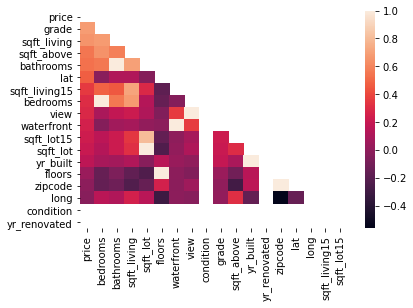

In [13]:
correlation_of_variable = correlation_of_variable.sort_values(by='price', ascending=False)
mask = np.triu(np.ones_like(correlation_of_variable, dtype=np.bool))
sns.heatmap(correlation_of_variable, mask=mask, color='red');

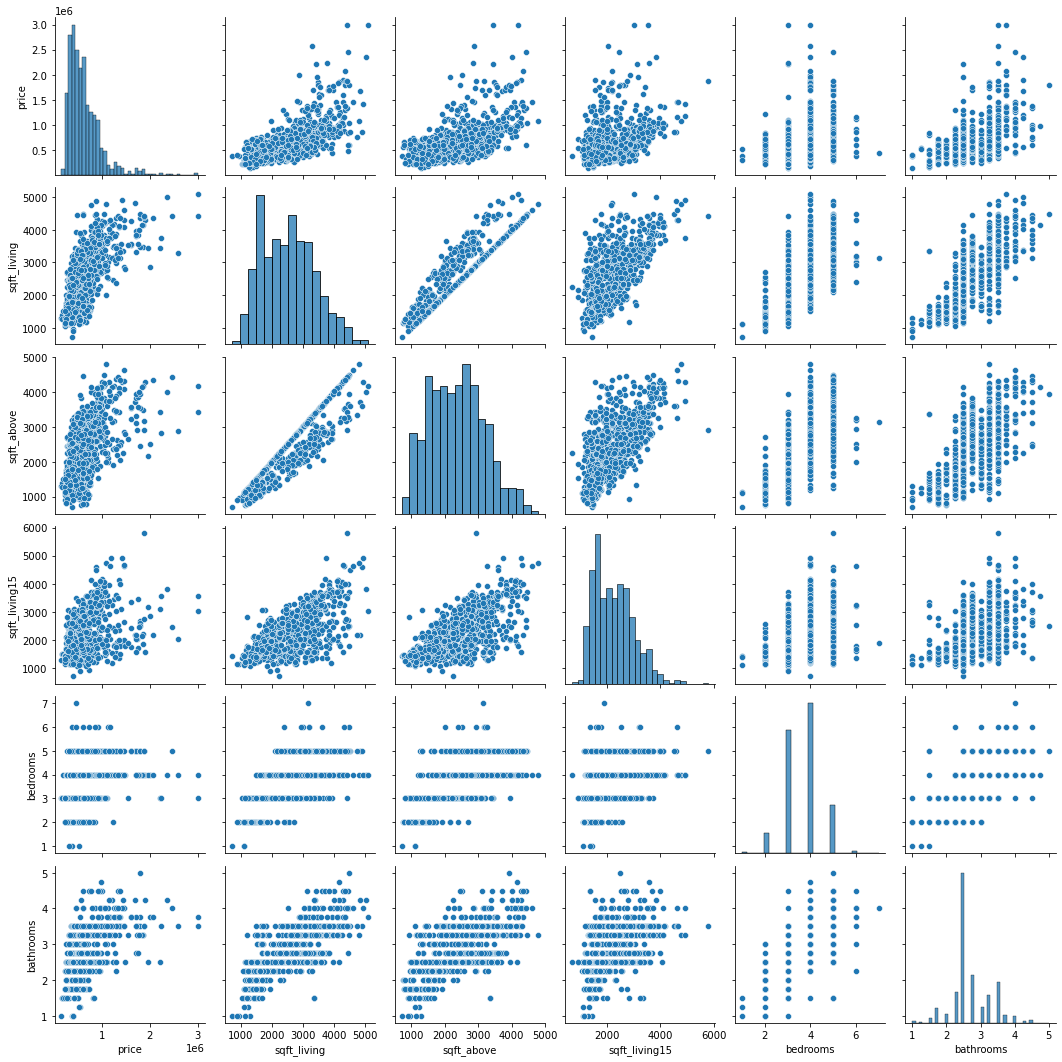

In [14]:
positively_correlated_values = house_data[['price', 'sqft_living', 'sqft_above', 'sqft_living15', 'bedrooms', 'bathrooms']]
sns.pairplot(positively_correlated_values)

In [15]:
positively_correlated_values.describe()

,price,sqft_living,sqft_above,sqft_living15,bedrooms,bathrooms
count,1.088000e+03,1088.000000,1088.000000,1088.000000,1088.000000,1088.000000
mean,6.317427e+05,2518.693015,2364.306985,2254.428309,3.677390,2.726103
std,3.472101e+05,836.391042,816.538475,733.933107,0.829407,0.568960
min,1.550000e+05,710.000000,710.000000,700.000000,1.000000,1.000000
25%,3.900000e+05,1797.500000,1687.500000,1627.500000,3.000000,2.500000
50%,5.499725e+05,2500.000000,2360.000000,2160.000000,4.000000,2.500000
75%,7.750000e+05,3130.000000,2910.000000,2730.000000,4.000000,3.000000
max,3.000000e+06,5090.000000,4800.000000,5790.000000,7.000000,5.000000


In [16]:
first_model_DataFrame = house_data[['price', 'sqft_living']].copy()
first_model = ols(formula='price ~ sqft_living', data=first_model_DataFrame)
first_model_results = first_model.fit()
first_model_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.427
Model:                            OLS   Adj. R-squared:                  0.427
Method:                 Least Squares   F-statistic:                     809.7
Date:                Wed, 19 May 2021   Prob (F-statistic):          1.55e-133
Time:                        08:13:46   Log-Likelihood:                -15121.
No. Observations:                1088   AIC:                         3.025e+04
Df Residuals:                    1086   BIC:                         3.026e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept   -5.161e+04   2.53e+04     -2.040      0.042   -1.01e+05   -1959.006
sqft_living   271.3110      9.534     28.456      0.000     252.603     290.019
==============================================================================
Omnibus:                      480.565   Durbin-Watson:                   1.843
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             3370.939
Skew:                           1.894   Prob(JB):                         0.00
Kurtosis:                      10.747   Cond. No.                     8.42e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 8.42e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

<AxesSubplot:xlabel='sqft_living', ylabel='price'>

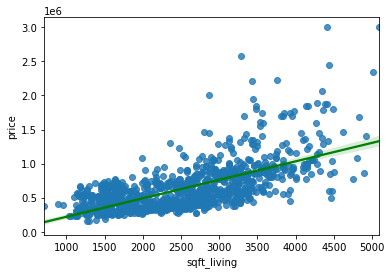

In [17]:
sns.regplot(x='sqft_living', y='price', data=first_model_DataFrame, line_kws={'color':'green'})

### First Model Evaluation

The summary of this model indicates that:
* 42.7% of the variance in our dependent variable is explained by the variance in our independent variable.
* Both coefficients are statistically significant at an alpha of 0.05
* One unit of change in the square footage of living space has an effect of $271.31

 #### Assumption of Linearity<br>&emsp;(for first model)

In [18]:
rainbow_p_value = linear_rainbow(first_model_results)[1]
print('Rainbow p-value:', rainbow_p_value)

Rainbow p-value: 1.6287204724380758e-10


The returned p value indicates that we reject the null hypothesis and therefore, violate the assumption of linearity.

#### Assumption of Normality<br>&emsp;(for first model)

array([[<AxesSubplot:title={'center':'price'}>,
        <AxesSubplot:title={'center':'sqft_living'}>]], dtype=object)

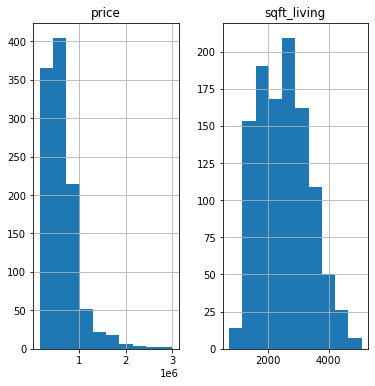

In [19]:
first_model_DataFrame.hist(figsize = [6,6])

<ipython-input-20-8b6384db4d61>:3: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


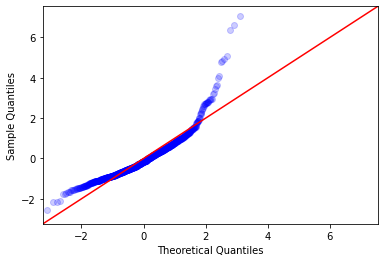

In [20]:
residuals = first_model_results.resid
fig = sm.graphics.qqplot(residuals, dist=stats.norm, fit=True, line='45', alpha=0.2)
fig.show()

The visualizations above display a skewed right distribution.<br>
The probability value returned by the Jarque-Bera indicates that we reject the null hypothesis and therefore,<br>
violate the assumption of normality.

#### Assumption of Homoscadasticity<br>&emsp;(for first model)

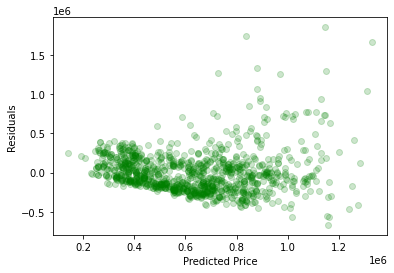

In [21]:
y_hat = first_model_results.predict()
fig1, ax1 = plt.subplots()
ax1.scatter(x=y_hat, y=residuals, color='green', alpha=0.2)
ax1.set(xlabel='Predicted Price',
        ylabel='Residuals');

### Second Model Evaluation

In [22]:
log_target = pd.DataFrame([])
log_target['log_price'] = np.log(first_model_DataFrame['price'])
log_target['sqft_living'] = first_model_DataFrame['sqft_living']

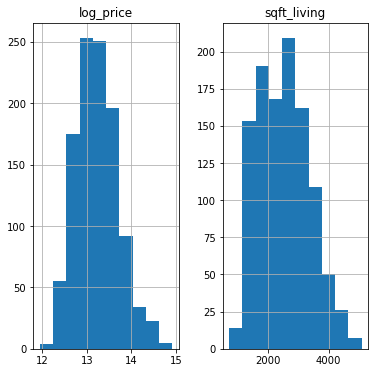

In [23]:
log_target.hist(figsize = [6,6]);

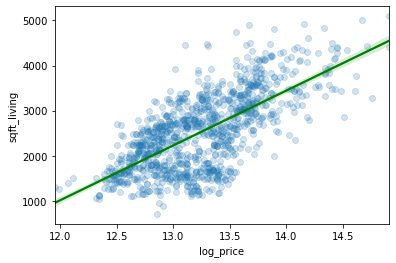

In [24]:
sns.regplot(x='log_price', y='sqft_living', data=log_target, scatter_kws={'alpha':0.2}, line_kws={'color':'green'});

In [25]:
second_model_DataFrame = log_target.copy()
second_model_DataFrame.dropna(inplace=True)
second_model_ols = ols(formula='log_price ~ sqft_living', data = second_model_DataFrame)
ssm_results = second_model_ols.fit()

In [26]:
ssm_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              log_price   R-squared:                       0.464
Model:                            OLS   Adj. R-squared:                  0.463
Method:                 Least Squares   F-statistic:                     938.9
Date:                Wed, 19 May 2021   Prob (F-statistic):          4.25e-149
Time:                        08:13:48   Log-Likelihood:                -381.00
No. Observations:                1088   AIC:                             766.0
Df Residuals:                    1086   BIC:                             776.0
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept      12.2767      0.033    371.100      0.000      12.212      12.342
sqft_living     0.0004   1.25e-05     30.641      0.000       0.000       0.000
==============================================================================
Omnibus:                       30.833   Durbin-Watson:                   1.894
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               23.623
Skew:                           0.269   Prob(JB):                     7.42e-06
Kurtosis:                       2.518   Cond. No.                     8.42e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 8.42e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

The summary of this model indicates that:
* 46.4% of the variance in our dependent variable is explained by the variance in our independent variable,<br>
an improvement from our first model.
* Both coefficients are statistically significant at an alpha of 0.05
* To scale our data after the log transformation of the target variable we interpret the sqft_living coefficient<br>
to mean that a one unit change in the square footage of living space has an effect of .04% change in price.

#### Assumption of Linearity<br>&emsp;(for second model)

In [27]:
second_rainbow_p_value = linear_rainbow(ssm_results)[1]
print('Rainbow p-value:', second_rainbow_p_value)

Rainbow p-value: 0.035291279700383794


The returned p value implies that we again reject the null hypothesis and therefore, we do not meet the assumption of linearity.

#### Assumption of Normality<br>&emsp;(for second model)

The p value returned by the Jarque-Bera indicates that we reject the null hypothesis and therefore,<br>
also violate the assumption of normality. However, visually our data seems to far more closely fit a standard distribution<br> when compared to our first model.

<ipython-input-28-5e42cc3d21c1>:3: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


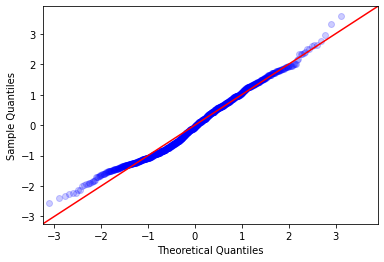

In [28]:
residuals = ssm_results.resid
fig = sm.graphics.qqplot(residuals, dist=stats.norm, fit=True, line='45', alpha=0.2)
fig.show()

#### Assumption of Homoscadasticity<br>&emsp;(for second model)

In [29]:
y = second_model_DataFrame['log_price']
y_hat = ssm_results.predict()

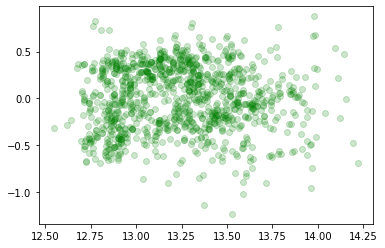

In [30]:
fig1,ax1 = plt.subplots()
ax1.scatter(x=y_hat, y=y_hat-y, color='green', alpha=0.2);

This scatterplot seems to show homoscedasticity, failing to reject the null hypothesis and therefore, meeting the assumption of homoscedasticity.

## Model 3

In [31]:
third_model_DataFrame = pd.DataFrame([])
third_model_DataFrame = house_data[['sqft_living', 'bedrooms']].copy()
third_model_DataFrame['log_price'] = log_target['log_price']
third_model_DataFrame.dropna(inplace=True)
third_model = ols(formula='log_price ~ sqft_living + bedrooms', data=third_model_DataFrame)
third_model_results = third_model.fit()
third_model_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              log_price   R-squared:                       0.493
Model:                            OLS   Adj. R-squared:                  0.492
Method:                 Least Squares   F-statistic:                     528.1
Date:                Wed, 19 May 2021   Prob (F-statistic):          6.91e-161
Time:                        08:13:49   Log-Likelihood:                -350.12
No. Observations:                1088   AIC:                             706.2
Df Residuals:                    1085   BIC:                             721.2
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept      12.5394      0.046    272.102      0.000      12.449      12.630
sqft_living     0.0005   1.66e-05     28.470      0.000       0.000       0.001
bedrooms       -0.1331      0.017     -7.961      0.000      -0.166      -0.100
==============================================================================
Omnibus:                       23.402   Durbin-Watson:                   1.893
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               18.769
Skew:                           0.240   Prob(JB):                     8.40e-05
Kurtosis:                       2.571   Cond. No.                     1.25e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.25e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### Third Model Evaluation

The summary of this model indicates that:
* 49.3% of the variance in our dependent variable is explained by the variance in our independent variables.
* All three coefficents are statistically significant at an alpha of 0.05
* Again scaling our data we interpret the 

#### Assumption of Linearity<br>&emsp;(for third model)

In [32]:
third_rainbow_p_value = linear_rainbow(third_model_results)[1]
print('Rainbow p-value:', third_rainbow_p_value)

Rainbow p-value: 0.02527527409391735


The returned p value indicates that we reject the null hypothesis and therefore, are still violating the assumption of linearity.

#### Assumption of Normality<br>&emsp;(for third model)

array([[<AxesSubplot:title={'center':'sqft_living'}>,
        <AxesSubplot:title={'center':'bedrooms'}>],
       [<AxesSubplot:title={'center':'log_price'}>, <AxesSubplot:>]],
      dtype=object)

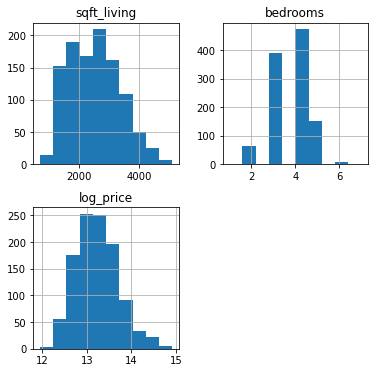

In [33]:
third_model_DataFrame.hist(figsize = [6,6])

<ipython-input-34-b3ad46eb83c2>:3: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


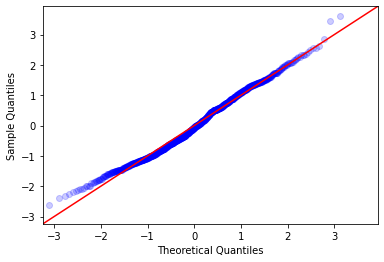

In [34]:
third_residuals = third_model_results.resid
fig = sm.graphics.qqplot(third_residuals, dist=stats.norm, fit=True, line='45', alpha=0.2)
fig.show()

The probability value returned by the Jarque-Bera indicates that we reject the null hypothesis and therefore,<br>
are again violating the assumption of normality.

#### Assumption of Homoscadasticity<br>&emsp;(for third model)

In [35]:
y3 = third_model_DataFrame['log_price']
y3_hat = third_model_results.predict()

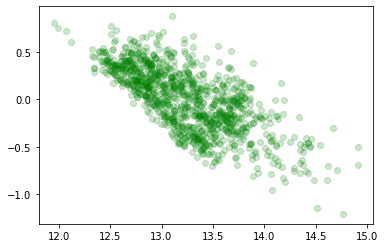

In [36]:
fig3,ax3 = plt.subplots()
ax3.scatter(x=y3, y=y3_hat-y3, color='green', alpha=0.2);

This scatterplot shows heteroscedasticity, rejecting the null hypothesis and therefore, violating the assumption of homoscedasticity.

#### Independence<br>&emsp;(for third model)

In [37]:
rows = third_model_DataFrame[['sqft_living','bedrooms']].values
variance_inflation_DataFrame = pd.DataFrame()
variance_inflation_DataFrame['vif'] = [variance_inflation_factor(rows, i) for i in range(2)]

In [39]:
variance_inflation_DataFrame

,vif
0,18.847989
1,18.847989


The condition number returned in the regression results indicates a strong multicollinearity.